Declare all required import packages.

In [54]:
"""
This code file creates homework assignment #2

Gary Gregg
DATA 512A
University of Washington
Autumn 2017

"""

import numpy as np
import csv
import matplotlib.pyplot as plt
plt.rcdefaults()
import os.path
import requests

Although they refer to the same country, some of the country names in the article data file do not match those in the population data file.  Create a map from one to the other.

In [55]:
# Country Map
COUNTRY_MAP = {
    "East Timorese" : "Timor-Leste",
    "Hondura" : "Honduras",
    "Rhodesian" : "Zimbabwe",
    "Salvadoran" : "El Salvador",
    "Samoan" : "Samoa",
    "São Tomé and Príncipe" : "Sao Tome and Principe",
    "Somaliland" : "Somalia",
    "South African Republic" : "South Africa",
    "South Korean" : "Korea, South"
}

Declare below field offsets for each kind of record list we use.  The offsets for the 'augmented' data file will be the same as those for the article (or page) data file, except that they append article quality and country population.  The count record will contain synthesized data that needs to be graphed including the two required percentage values.  The article (or page) data file is one of our input files, as is the population data file.

In [56]:
# Augmented Page Data Fields
AUG_COUNTRY = 0
AUG_PAGE = 1
AUG_REVISION_ID = 2
AUG_QUALITY = 3
AUG_POPULATION = 4

# Count Fields
CNT_COUNTRY = 0
CNT_POPULATION = 1
CNT_ARTICLES = 2
CNT_ARTICLE_PCT = 3
CNT_HQ_ARTICLES = 4
CNT_HQ_ARTICLE_PCT = 5

# Page Data Fields
PDT_COUNTRY = 0
PDT_PAGE = 1
PDT_REVISION_ID = 2

# Population Fields
POP_COUNTRY = 0
POP_CNT_TYPE = 1
POP_TIMEFRAME = 2
POP_DATATYPE = 3
POP_DATA = 4
POP_FOOTNOTES = 5

Declare and initialize global constants.

In [57]:
# Miscellaneous Constants
AUGMENTED_PAGE_DATA_PATH = 'data-512-a2.csv'
DEFAULT_ROW_COUNT = 2
MODEL = 'wp10'
PAGE_DATA_PATH = 'page_data.csv'
POPULATION_DATA_PATH = 'Population Mid-2015.csv'
PER_CALL = 140
PROJECT = 'enwiki'

The augment_page_data function augments rows from the article data file with a quality rating and a country population.  The quality rating is supplied by a quality dictionary indexed by revision ID, and the population dictionary is indexed by country name.

In [58]:
def augment_page_data(page_data, quality_dictionary, population_dictionary):
    """
    Augments page data with article quality and the population of the country
    in which the subject resides.

    @param page_data: The original page data
    @type page_data: list
    @param quality_dictionary: An article quality dictionary, indexed by
    revision ID
    @type quality_dictionary: dict
    @param population_dictionary: A population dictionary, indexed by country
    @type population_dictionary: dict
    @return: Page data augmented with article quality and the population of the
    country in which the subject resides
    @rtype: list
    """

    # Declare and initialize a dictionary of missing countries, and a list to
    # received the augmented page data.
    missing = {}
    new_page_data = [['country',
                      'article_name',
                      'revision_id',
                      'article_quality',
                      'population']]

    # Cycle for each row in the page data.
    for index in range(1, len(page_data)):

        # Get the indexed row.  Get the article revision and country name
        # for the first/next row.
        row = page_data[index]
        article_revision = row[PDT_REVISION_ID]
        country_name = get_country(row[PDT_COUNTRY])

        # Write a message if the article revision is not in the quality
        # dictionary.  This really should not happen.
        if article_revision not in quality_dictionary:
            print('Missing quality entry for revision ID \'%s\'.' %
                  article_revision)

        # The article revision is in the quality dictionary.
        else:

            # Initialize, or increment the count of articles for the
            # given country name if the country name is not in the
            # population dictionary.
            if country_name not in population_dictionary:

                if country_name not in missing:
                    missing[country_name] = 1
                else:
                    missing[country_name] += 1

            # The country is in the population dictionary.  Create
            # an augmented page data row.
            else:
                new_page_data.append([country_name,
                                      row[PDT_PAGE],
                                      article_revision,
                                      quality_dictionary[article_revision],
                                      population_dictionary[country_name]])

    # Describe the counts of articles for 'countries' that were missing
    # a population in the population dictionary.  Return the augmented page
    # data.
    print('The following is the counts of articles about persons in countries '
          'that are missing a registered population: %s' % missing)
    return new_page_data

The build_country_to_population function builds a dictionary of country names to the corresponding country's population.

In [59]:
def build_country_to_population(country_data):
    """
    Builds a dictionary of countries to their populations.

    @param country_data: A list of countries with name as the first field,
    and population as the fifth field
    @type country_data: list
    @return: A dictionary of countries to their population
    @rtype: dict
    """

    # Declare and initialize the population dictionary, and cycle for each
    # country in the list.
    population_dictionary = {}
    for index in range(3, len(country_data) - 1):

        # Add a new dictionary for the first/next country.
        population_dictionary[country_data[index][POP_COUNTRY]] =\
            int(country_data[index][POP_DATA].replace(',', ''))

    # Return the population dictionary.
    return population_dictionary

The calculate_percentages function calculates the article count to population percentage, and the good article count to article count percentage for each country.

In [60]:
def calculate_percentages(counts):
    """
    Calculates the percentage of articles per population, and the percentage of
    high-quality articles for a country dictionary, list or tuple.

    @param counts: A country dictionary, list or tuple
    @type counts: dict, list or tuple
    @return: None
    @rtype: None
    """

    # Declare and initialize a percent multiplier.  Cycle for each country.
    percent = 100.
    for country in counts:

        # Get the value list for the first/next country.  Get the article count
        # and population from the list.
        value = counts[country]
        article_count = value[CNT_ARTICLES]
        population = value[CNT_POPULATION]

        # Calculate the percentage of articles per population if the population
        # is greater than zero.
        if population > 0:
            value[CNT_ARTICLE_PCT] = article_count / population * percent

        # Calculate the percentage of high-quality articles if there are one or
        # more articles.
        if article_count > 0:
            value[CNT_HQ_ARTICLE_PCT] = value[CNT_HQ_ARTICLES] / article_count * percent

    # Done, so return.
    return

The construct_display_values function constructs two lists, one for the top (or bottom) ten values to be displayed along the horizontal axis (which will be country names), and the top (or bottom) ten values to be displayed along the vertical axis (which will be percentages).  The function receives the indices of the display fields as its last two arguments.

In [61]:
def construct_display_values(value_list, horizontal, vertical):
    """
    Constructs two lists of display values, one for the horizontal axis, and
    one for the vertical axis.

    @param value_list: A list containing the display values
    @type value_list: list or tuple
    @param horizontal: The index of the horizontal display values
    @type horizontal: int
    @param vertical: The index of the vertical display values
    @type vertical: int
    @return: Two lists
    @rtype: list
    """

    # Declare and initialize the lists to be returned.  Cycle for the number of
    # items to be displayed.
    horizontal_list = []
    vertical_list = []
    for i in range(0, 10):

        # Add the values for the first/next item in the list.
        horizontal_list.append(value_list[i][horizontal])
        vertical_list.append(value_list[i][vertical])

    return horizontal_list, vertical_list

The function create_assignment_2 is the starting point for this show.  It creates the augmented article (or page) data file, calculates the percentages to be displayed, then creates the four bar graphs required by the assignment.

In [62]:
def create_assignment_2():
    """
    Creates homework assignment #2.  No input parameters or return value.
    Everything this function does is a side-effect.

    @return: None
    @rtype: None
    """

    # Create the country list.
    country_list = list(create_country_dictionary().values())

    # Sort the country list by descending article/population percentage, and
    # graph it.
    sort_and_display(country_list, get_article_percentage, CNT_ARTICLE_PCT,
                     True,
                     'Highest-Ranked Countries in Terms of Number of Politician '
                     'Articles as a Proportion of Country Population')

    # Sort the country list by ascending article/population percentage, and
    # graph it.
    sort_and_display(country_list, get_article_percentage, CNT_ARTICLE_PCT,
                     False,
                     'Lowest-Ranked Countries in Terms of Number of Politician '
                     'Articles as a Proportion of Country Population')

    # Sort the country list by descending high-quality/all-article percentage,
    # and graph it.
    sort_and_display(country_list, get_hq_article_percentage, CNT_HQ_ARTICLE_PCT,
                     True,
                     'Highest-Ranked Countries in Terms of Number of GA and '
                     'FA-Quality Articles as a Proportion of all Articles '
                     'About Politicians from that Country')

    # Sort the country list by ascending high-quality/all-article percentage,
    # and graph it.
    sort_and_display(country_list, get_hq_article_percentage, CNT_HQ_ARTICLE_PCT,
                     False,
                     'Lowest-Ranked Countries in Terms of Number of GA and '
                     'FA-Quality Articles as a Proportion of all Articles '
                     'About Politicians from that Country')

The function create_augmented_page_data creates the augmented page data file from the article data file and the population data file.

In [63]:
def create_augmented_page_data():
    """
    Creates the augmented page data file.

    @return: None
    @rtype: None
    """

    # Read the page data from CSV.  Create the page quality map, and the
    # country-to-population map.  Using all of these, create the augmented
    # page data and write it to CSV.
    page_data = read_from_csv(PAGE_DATA_PATH)
    write_to_csv(AUGMENTED_PAGE_DATA_PATH,
                 augment_page_data(page_data,
                                   get_quality_all(page_data, 101),
                                   build_country_to_population(
                                       read_from_csv(POPULATION_DATA_PATH))))

The function create_country_dictionary creates a dictionary of statistics about a country, indexed by the country name.

In [64]:
def create_country_dictionary():
    """
    Creates a dictionary of countries, and statistics about them.
    Precondition: The augmented page data file exists, and is formatted
    correctly.

    @return: A dictionary of countries, and statistics about them
    @rtype: dict
    """

    # Here is the current list of fields for values in the dictionary:
    #
    # CNT_COUNTRY
    # CNT_POPULATION
    # CNT_ARTICLES
    # CNT_ARTICLE_PCT
    # CNT_HQ_ARTICLES
    # CNT_HQ_ARTICLE_PCT

    # Initialize an empty country dictionary.  Read rows from the augmented
    # page data file.
    country_dictionary = {}
    augmented_page_data = read_augmented_csv()

    # Delete the header row from the augmented page data.  Cycle for each
    # remaining row in the file.
    del augmented_page_data[0]
    for data_row in augmented_page_data:

        # Extract the country name from the row.  Is there an existing entry
        # in the country dictionary.  Get it if so.
        country = data_row[AUG_COUNTRY]
        if country in country_dictionary:
            country_row = country_dictionary[country]

        # There is no existing entry in the country dictionary.  Create one
        # with initial values.
        else:
            country_row = [country, int(data_row[AUG_POPULATION]),
                           0, 0., 0, 0.]

        # Increment the count of articles for the given country.
        country_row[CNT_ARTICLES] += 1

        # Get the quality from the data row.  Increment the count of high-
        # quality articles if the article has a high-quality rating.
        quality = data_row[AUG_QUALITY]
        if quality == 'FA' or quality == 'GA':
            country_row[CNT_HQ_ARTICLES] += 1

        # Return, or add the country value to the country dictionary indexed
        # by country.
        country_dictionary[country] = country_row

    # Calculate the percentage of articles per population, and the percentage
    # of high-quality articles.
    calculate_percentages(country_dictionary)
    return country_dictionary

The function display_barchart displays a barchart given the horizontal axis values, the vertical axis values, and a graph title.

In [65]:
def display_barchart(horizontal_values, vertical_values, title):
    """
    Displays a barchart of country to percentage.

    @param horizontal_values: Country names to be displayed along the
    horizontal axis
    @type horizontal_values: str
    @param vertical_values: Percentages to be displayed along the vertical axis
    @type vertical_values: float
    @param title: Title for the graph
    @type title: str
    @return: None
    @rtype: None
    """

    # Set the figure size.  Declare and initialize an array of evenly spaced
    # values.  Construct the plot.
    plt.figure(figsize=(20, 10))
    y_position = np.arange(len(horizontal_values))
    plt.bar(y_position, vertical_values, align='center', alpha=1.0,
            color=['#66cdaa'])  # Color is Medium Aquamarine

    # Set the x-ticks, the x-label and the y-label.
    plt.xticks(y_position, horizontal_values)
    plt.xlabel('Country Name')
    plt.ylabel('Percentage')

    # Set the title, and show the graph.
    plt.title(title)
    plt.show()

The function get_article_percentage gets the article percentage field from a row in a country statistics list.  This method is used by 'sorted' to sort the country statistics list by the article percentage field.

In [66]:
def get_article_percentage(country):
    """
    Gets the percentage of articles to population from a list.

    @param country: A country attributes entry
    @type country: list
    @return: Percentage of articles to population
    @rtype: float
    """
    return country[CNT_ARTICLE_PCT]

The function get_article_quality uses the Wikimedia ORES API to retrieve article quality for a series of articles given by revision ID.

In [67]:
def get_article_quality(article_quality, revision_ids):
    """
    Gets predicted article quality for a series of revision IDs.  Returns a dictionary
    indexed by revision ID.  Possible values for each revision ID are:

    FA - Featured article
    GA - Good article
    B - B-class article
    C - C-class article
    Start - Start-class article
    Stub - Stub-class article

    @param article_quality: An existing dictionary of revision IDs to
    article quality
    @type article_quality: dictionary
    @param revision_ids: A series of revision IDs
    @type revision_ids: list or tuple
    @return: article_quality
    @rtype: dict
    """

    # Hardcoded endpoint for the ORES API
    endpoint = 'https://ores.wikimedia.org/v3/scores/{project}/?models={model}&revids={revids}'

    # The parameters to be passed to the ORES API
    params = {'project': PROJECT,
              'model': MODEL,
              'revids': '|'.join(str(x) for x in revision_ids)
             }

    # Call the API, and return the response as JSON.
    api_call = requests.get(endpoint.format(**params))
    response = api_call.json()

    # Build and return a dictionary of article quality predictions
    # indexed by revision ID. Return the article quality dictionary.
    for key, value in response[PROJECT]['scores'].items():
        article_quality[key] = value[MODEL]['score']['prediction']
    return article_quality

The function get_country uses the COUNTRY_MAP to return possibly alternate country names used in the population data file.  If the names used are different, it returns the different name.  Otherwise it returns the name used in the article data file.

In [68]:
def get_country(country):
    """
    Determines if a given country is mapped to another name.

    @param country: A given country
    @type country: str
    @return: A mapped country name if a name exists in the country map,
    the unmapped parameter otherwise
    @rtype: str
    """

    # Reset the country name if a name exists in the country map, and
    # return the country.
    if country in COUNTRY_MAP:
        country = COUNTRY_MAP[country]
    return country

The function get_hq_article_percentage gets the high-quality article percentage field from a row in a country statistics list. This method is used by 'sorted' to sort the country statistics list by the high-quality article percentage field.

In [69]:
def get_hq_article_percentage(country):
    """
    Gets the percentage of high-quality articles from a list.

    @param country: A country attributes entry
    @type country: list
    @return: Percentage of high-quality articles from a list
    @rtype: float
    """
    return country[CNT_HQ_ARTICLE_PCT]

I discovered that the Wikimedia ORES API will not successfully return quality statistics for more than about 140 articles at a time.  The get_quality_all function will get quality statistics for all rows in the article data file by calling the ORES API as many times as it needs to, asking for no more than 140 articles at a time.

In [70]:
def get_quality_all(page_data, last_index=DEFAULT_ROW_COUNT):
    """
    Gets article quality for all revision IDs in a page data list, up
    to a given maximum.

    @param page_data: A page data list, formatted with revision ID as the
    third element in each row
    @type page_data: list or tuple
    @param last_index: The last index to consider
    @type last_index: int
    @return: article_quality
    @rtype: dict
    """

    # Use the the full length of the page data if the last index is less than
    # a minimum number of rows.
    if last_index <= DEFAULT_ROW_COUNT:
        last_index = len(page_data)

    # Declare and initialize the quality dictionary, and determine the number
    # of iterative calls.
    quality_dictionary = {}
    calls = last_index // PER_CALL

    # Declare and initialize the base index, and cycle for the given number of
    # full calls required to retrieve the indicated number of rows.
    base = 1
    for _ in range(0, calls):

        # Calculate the last index, and print a message.
        count = base + PER_CALL
        print('Retrieving quality rating for articles %d to %d...'
              % (base, count - 1))

        # Update the quality dictionary.
        quality_dictionary = make_quality_call(quality_dictionary,
                                               page_data,
                                               base,
                                               count)

        # Update the base index.
        base = count

    # Is the base index less than the last index?  If so, there is
    # a remaining number of rows...
    if base < last_index:

        # Print a message.
        print('Retrieving quality rating for articles %d to %d...' %
              (base, last_index - 1))

        # Update the quality dictionary with the remaining number of rows.
        quality_dictionary = make_quality_call(quality_dictionary,
                                               page_data,
                                               base,
                                               last_index)

    # Describe how long the dictionary is, and return is.
    print('Length of quality dictionary is %d' % len(quality_dictionary))
    return quality_dictionary

The function make_quality_call assists in batch calling of the ORES API by creating a list of only the desired 140 revision IDs.  It then calls ORES with these revision IDs, and adds the results to an existing article quality dictionary, which is slowly built up until the quality ratings have been retrieved all the articles.

In [71]:
def make_quality_call(existing_dictionary, page_data, start, stop):
    """
    Makes a call to get article quality for a given set of indices into a page
    data list.

    @param existing_dictionary: An existing dictionary of quality entries
    indexed by revision ID
    @type existing_dictionary: dictionary
    @param page_data: A page data list, formatted with revision ID as the
    third element in each row
    @type page_data: list or tuple
    @param start: The first index to use, inclusive
    @type start: int
    @param stop: The last index, exclusive
    @type stop: int
    @return: article_quality
    @rtype: dict
    """

    # Declare and initialize an empty list of revision IDs.  Cycle for each row
    # in the given range.  Append the first/next ID to the list.
    ids = []
    for row in range(start, stop):
        ids.append(page_data[row][PDT_REVISION_ID])

    # Get article quality for the selected revision IDs.
    return get_article_quality(existing_dictionary, ids)

The read_augmented_csv function reads the augmented data file, which is the article data file with quality ratings and country population counts appended to each row.  Note that the function will use an existing augmented data file if its exists, or create a new one if it does not.

In [72]:
def read_augmented_csv():
    """
    Reads fields from the augmented page data file.

    @return: The rows read from the file
    @rtype: list
    """

    # Create the augmented page data file if it does not already exist.
    if not os.path.isfile(AUGMENTED_PAGE_DATA_PATH):
        create_augmented_page_data()

    # Read the file, and return the rows.
    return read_from_csv(AUGMENTED_PAGE_DATA_PATH)

The function read_from_csv reads rows from a CSV file.

In [73]:
def read_from_csv(file_name):
    """
    Reads fields from a CSV file.

    @param file_name: A file path.
    @type file_name: str
    @return: The rows read from the file
    @rtype: list
    """

    # Declare and initialize a empty row list.  Open a CSV reader using the
    # given file name.
    row_list = []
    with (open(file_name)) as csvfile:
        reader = csv.reader(csvfile)

        # Append the row for each row read by the reader.
        for row in reader:
            row_list.append(row)

    # Return the row list.
    return row_list

The function sort_and_display sorts a country statistics list using a supplied sort function, then display the top (or bottom) rows of the list with a percentage indicated by the percentage_index argument.  The sort and occur either ascending or descending, and the resulting display has the indicated title.

In [74]:
def sort_and_display(value_list, sorter, percentage_index, descending, title):
    """
    Sorts a values list, and displays a barchart.

    @param value_list: A list of values
    @type value_list: list
    @param sorter: The key function to use for sort
    @type sorter: function
    @param percentage_index: The index of the desired percentage in the value
    list
    @type percentage_index: int
    @param descending: True to sort largest to smallest, false otherwise
    @type descending: bool
    @param title: The title of the resulting graph
    @type title: str
    @return: None
    @rtype: None
    """

    # Sort the value list.  Extract values for the horizontal and vertical
    # axes.
    value_list = sorted(value_list, key=sorter, reverse=descending)
    horizontal, vertical = construct_display_values(value_list,
                                                    CNT_COUNTRY,
                                                    percentage_index)

    # Display a barchart with the extracted values and the given title.
    display_barchart(horizontal, vertical, title)

The function write_to_csv writes a row list in CSV format to a file with the indicated name.  In particular, this function is used to create the augmented data file.

In [75]:
def write_to_csv(file_name, row_list):
    """
    Writes fields to a CSV file.

    @param file_name: A file path.
    @type file_name: str
    @param row_list: The rows to write to the file
    @type row_list: list
    """

    # Open a CSV writer using the given file name.  Write the given rows.
    with(open(file_name, 'w')) as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(row_list)

Here is where the whole thing starts: Call create_assignment_2!

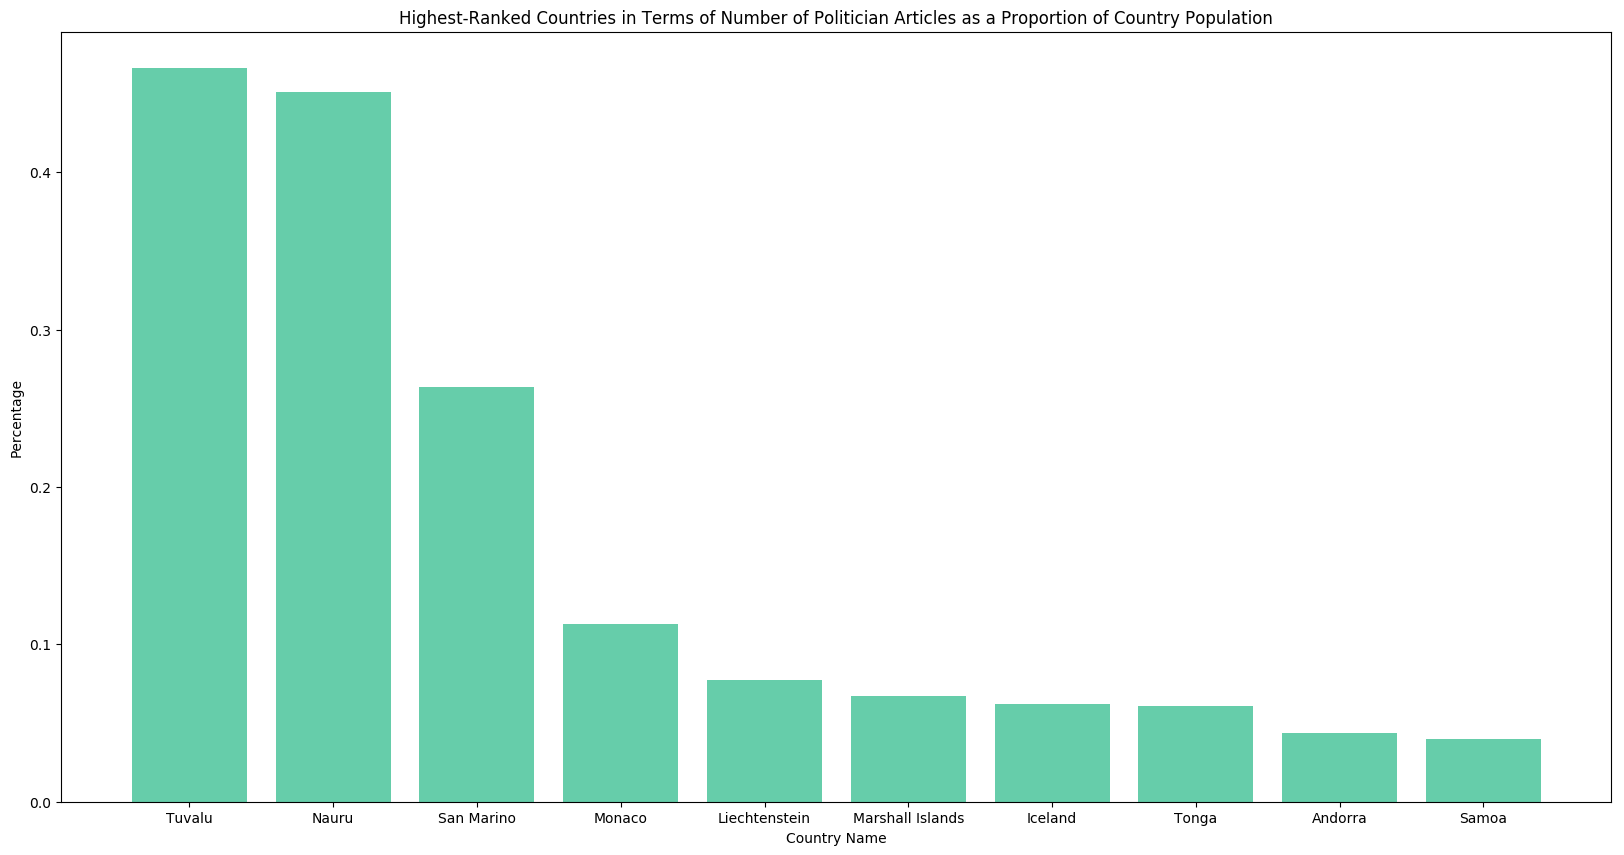

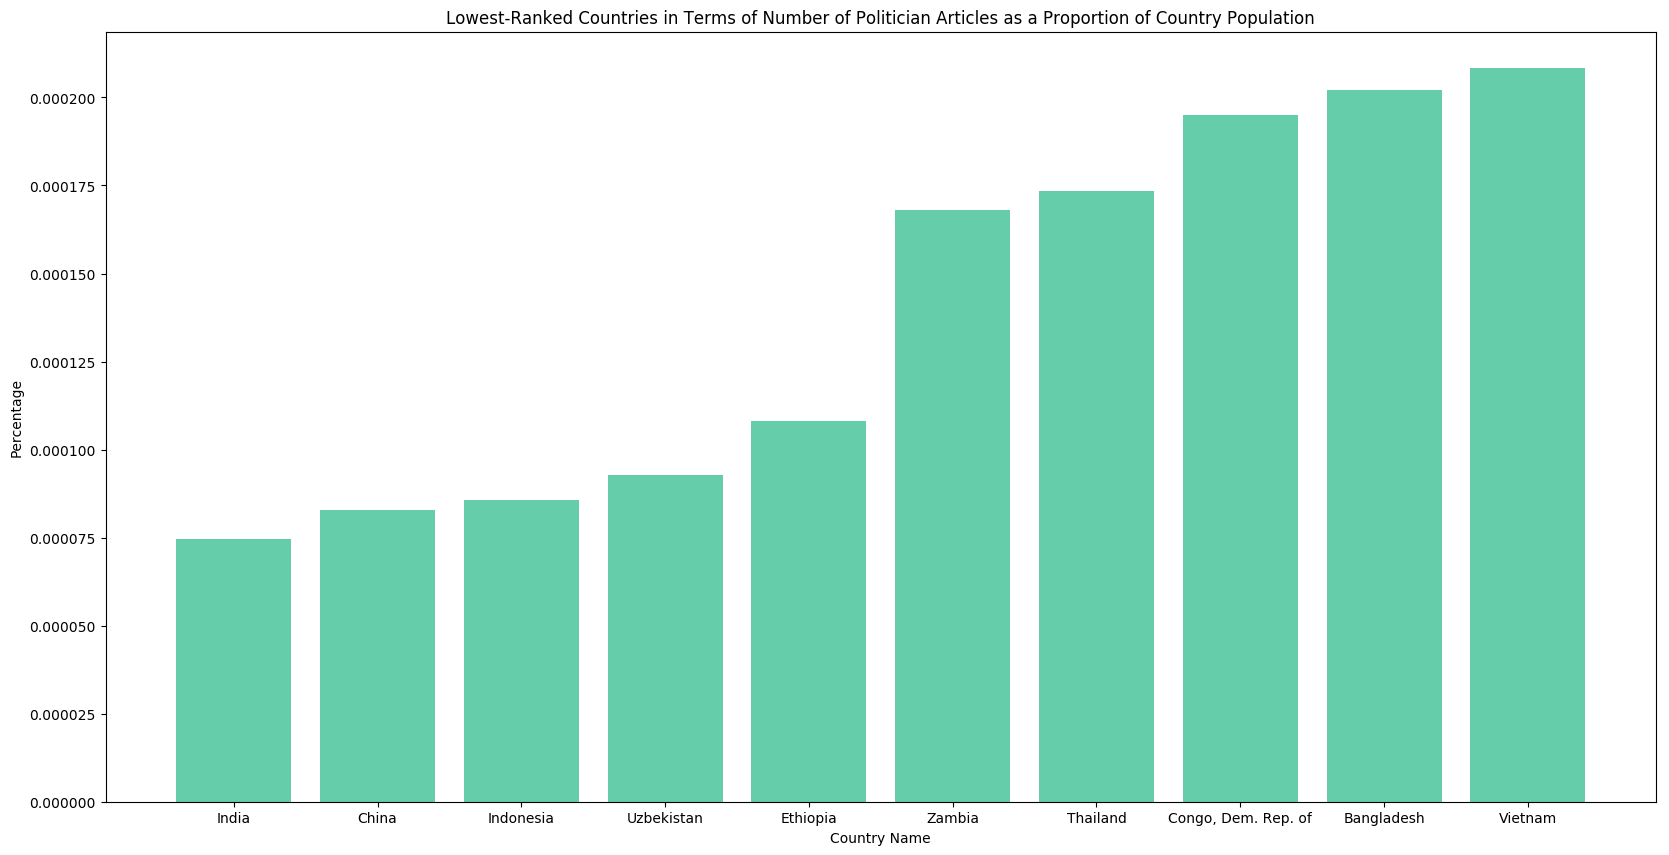

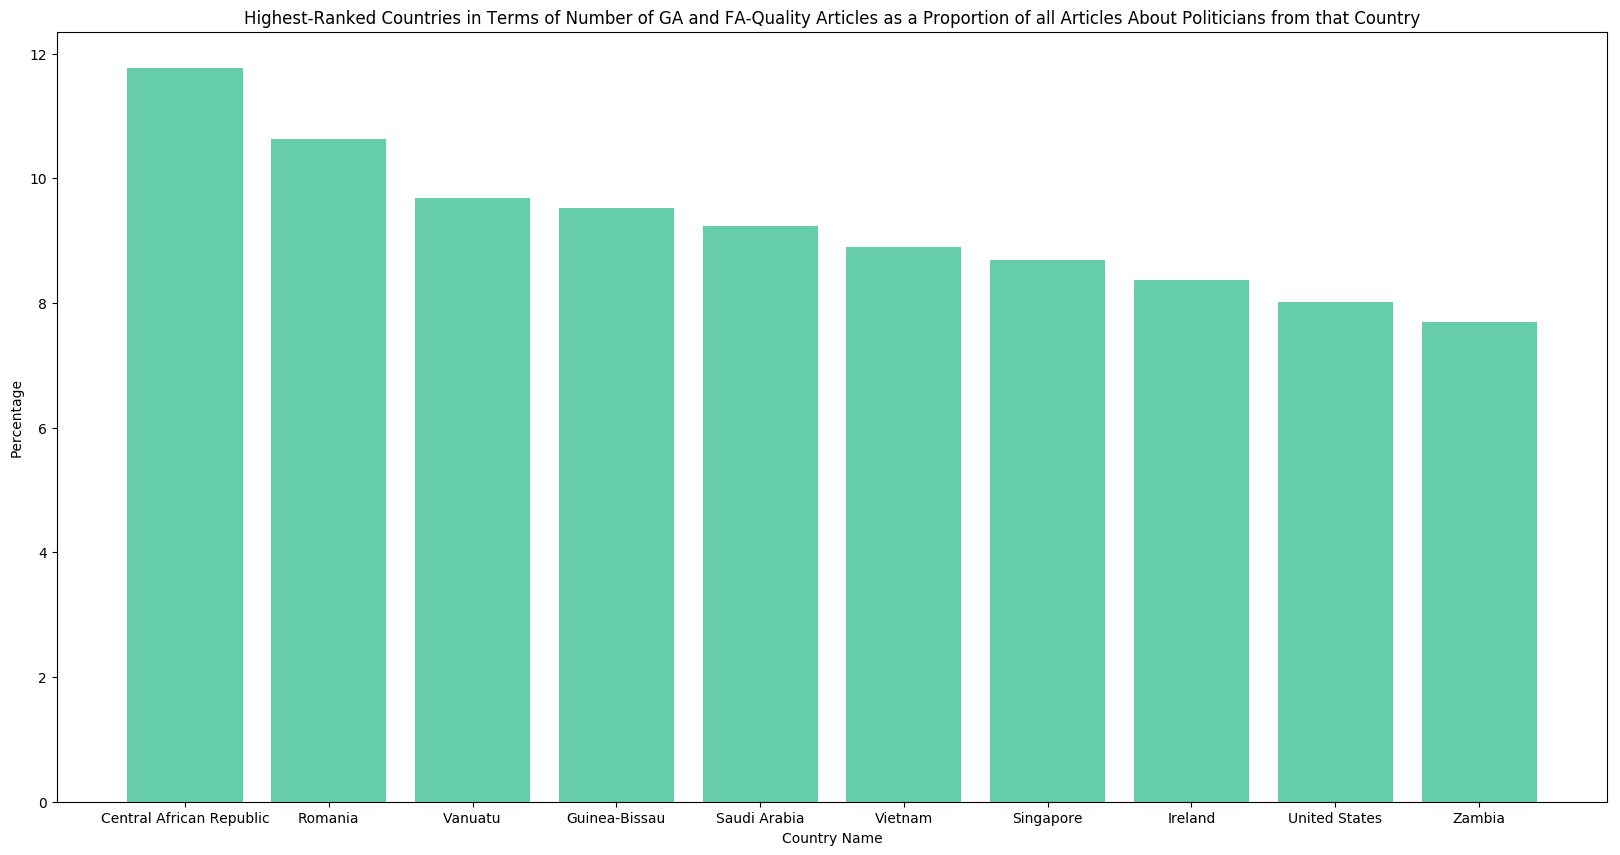

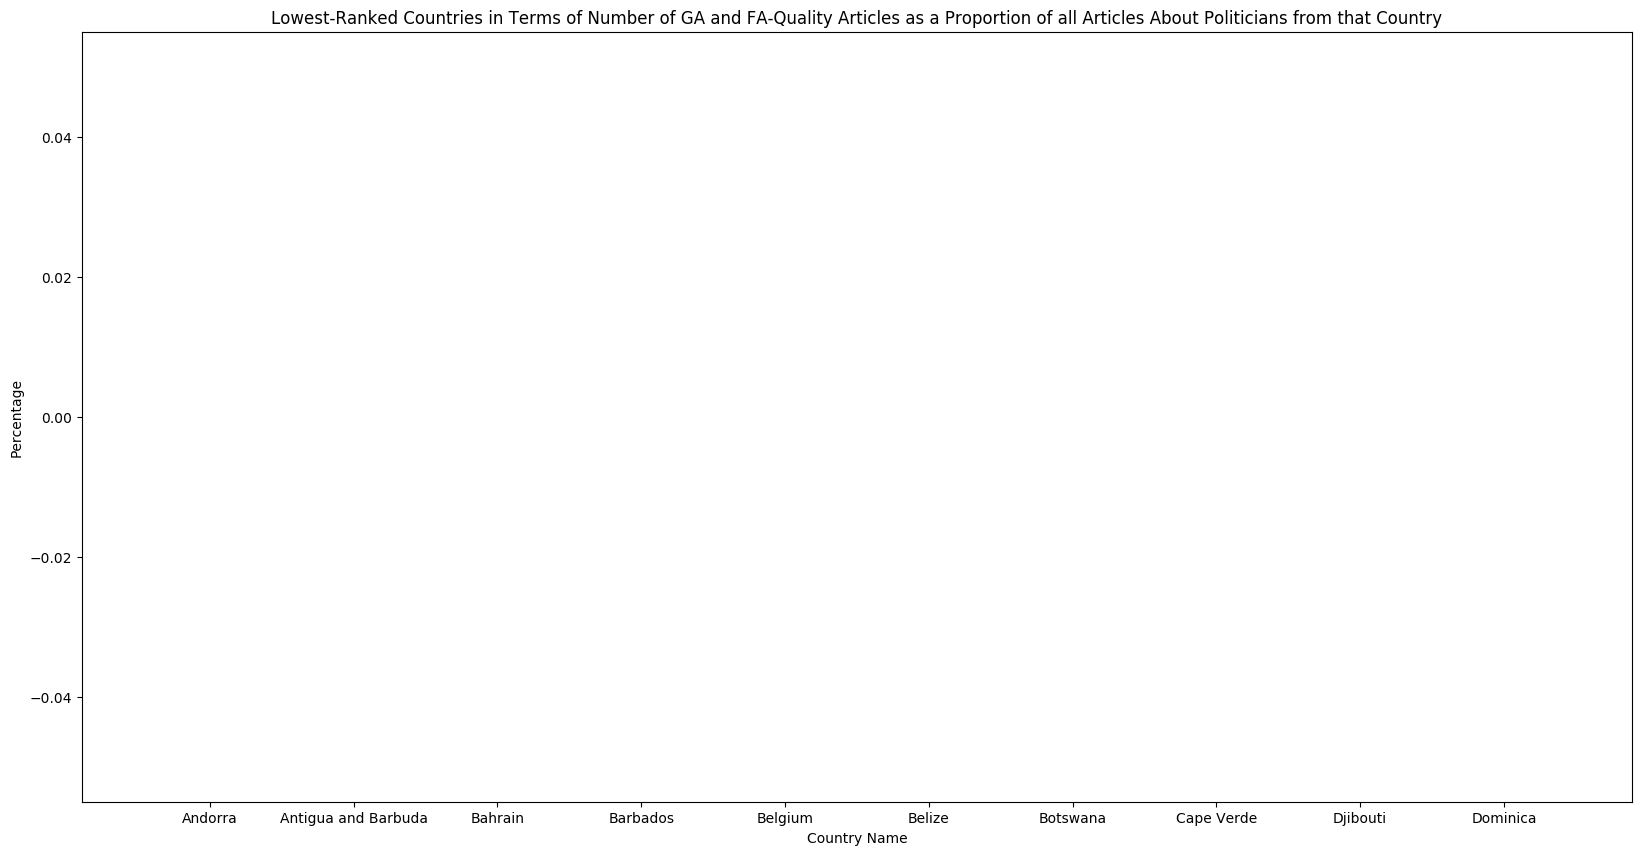

In [76]:
# Create the products for homework assignment #2.
create_assignment_2()